In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn.objects as so
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

### Reading the data

In [2]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/aclImdb/')

In [3]:
tr_d = text_dataset_from_directory( w_dir / 'train' )
va_d = text_dataset_from_directory( w_dir / 'validation' )
te_d = text_dataset_from_directory( w_dir / 'test' )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### TextVectorization

In [4]:
# configuring to get 1-gram
text_vectorization = layers.TextVectorization(
    max_tokens=20000,
    output_mode='multi_hot'
)

In [5]:
# text only no labels
text_only = tr_d.map( lambda x, y: x )

# Constructing the vocabulary
text_vectorization.adapt(text_only)

In [6]:
tr_1gram = tr_d.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
va_1gram = va_d.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)
te_1gram = te_d.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
tr_1gram = tr_1gram.prefetch(buffer_size=tf.data.AUTOTUNE)
va_1gram = va_1gram.prefetch(buffer_size=tf.data.AUTOTUNE)
te_1gram = te_1gram.prefetch(buffer_size=tf.data.AUTOTUNE)

### The model

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
print(f'Number of GPUs: {strategy.num_replicas_in_sync}')

Number of GPUs: 2


In [10]:
with strategy.scope():
    inputs = keras.Input(shape=(20000,))
    
    x = layers.Dense(32, activation='relu')(inputs)
    
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'BagOfWords(1-gram).keras',
        save_best_only=True
    ),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_1gram.cache(),
    epochs=43,
    validation_data=va_1gram.cache(),
    callbacks=callbacks
)

Epoch 1/43
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

### Test

In [13]:
model = keras.models.load_model('BagOfWords(1-gram).keras')

In [14]:
print(f'Test accuracy: {model.evaluate(te_1gram)[1]:.3f}')

782/782 [==============================] - 2s 2ms/step - loss: 0.2801 - accuracy: 0.8878
Test accuracy: 0.888


### Learning curves

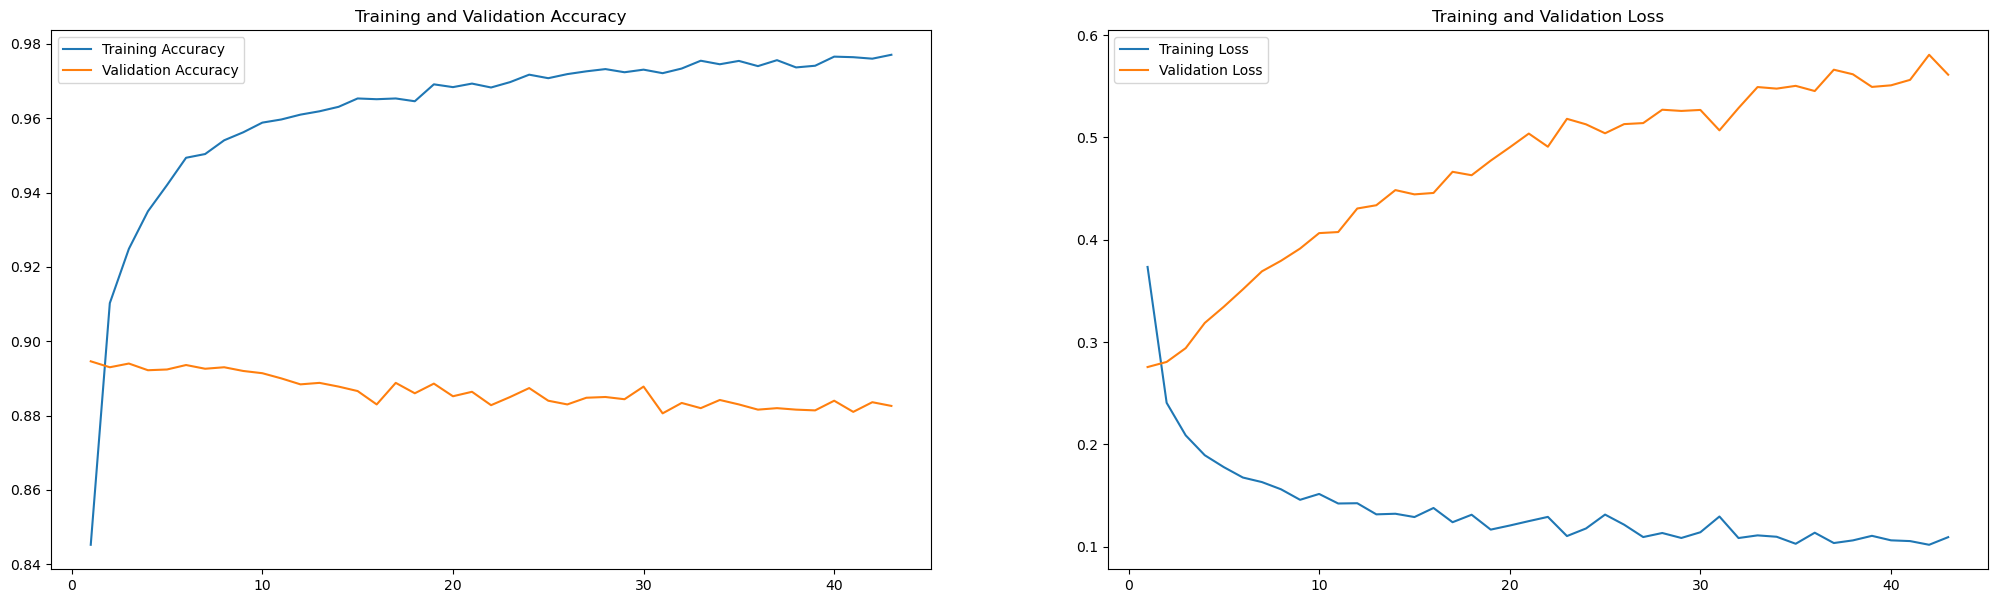

In [16]:
accuracy = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range( 1, len(accuracy) + 1 )

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_accu, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss' )
ax[1].set_title('Training and Validation Loss')
ax[1].legend();